# Introduction

First submission :

<a href='#1'>1. Loading Data</a>

<a href='#2'>2. Combining Datasets</a>

<a href='#3'>3. Memory Limitation</a>

<a href='#4'>4. Missing Values</a>

<a href='#5'>5.EDA</a>

<a href='#6'>6. Model Training</a>

<a href='#7'>7. Model Predictions and Kaggle Submission</a>

# <a id='1'>1. Loading Data</a>

In [2]:
#import libraries
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sn
import statistics

In [159]:
#load data
train = pd.read_csv('kaggle/input/ashrae-energy-prediction/train.csv')
train['timestamp'] = pd.to_datetime(train['timestamp']) #the train dataset contains a 'timestamp' column we convert to a datetime object for ease of use
test = pd.read_csv('kaggle/input/ashrae-energy-prediction/test.csv')
test['timestamp'] = pd.to_datetime(test['timestamp'])
weather_train = pd.read_csv('kaggle/input/ashrae-energy-prediction/weather_train.csv')
weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp']) 
weather_test = pd.read_csv('kaggle/input/ashrae-energy-prediction/weather_test.csv')
weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp']) 
build_meta = pd.read_csv('kaggle/input/ashrae-energy-prediction/building_metadata.csv')

In [160]:
len(train), len(test)

(20216100, 41697600)

In [161]:
train = train.sample(frac = 0.0005)
test = test.sample(frac = 0.0005)

In [162]:
train.shape

(10108, 4)

In [163]:
test.shape

(20849, 4)

For a simple first model, we are going to merge the training sets to gather all covariables and make predictions on it with a linear regressor.

# <a id='2'>2. Combining Datasets</a>
We will merge everything into train and test dataframes.

We need to convert the timestamp to the right type:

In [164]:
weather_test.timestamp = pd.to_datetime(weather_test.timestamp) 
weather_train.timestamp = pd.to_datetime(weather_train.timestamp) 

In [165]:
#merge the building meta data and weather data into the train data
train_m = train.merge(build_meta, how='left', on = ['building_id'], validate='many_to_one') #merge the building meta data into the train data
test_m = test.merge(build_meta, how='left', on = ['building_id'], validate='many_to_one') #merge the building meta data into the train data
train_m = train_m.merge(weather_train, how='left', on = ['site_id', 'timestamp'], validate='many_to_one')#add weather data to each time entry for each site ID
test_m = test_m.merge(weather_test, how='left', on = ['site_id', 'timestamp'], validate='many_to_one')#add weather data to each time entry for each site ID
del build_meta, weather_train, weather_test
import gc
gc.collect() #mandatory since we don't have unlimited space (16go and the databases are quite large)
train_m.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,98,1,2016-11-28 03:00:00,1646.2000,0,Lodging/residential,200933,2007.0,NaN,18.3,NaN,12.8,0.0,1019.7,80.0,2.6
1,1255,0,2016-12-27 09:00:00,47.0104,14,Office,23702,NaN,NaN,12.2,NaN,8.9,0.0,1013.9,220.0,8.2
2,1299,2,2016-04-10 10:00:00,621.1320,14,Education,25401,NaN,NaN,-1.1,0.0,-10.6,0.0,1023.9,300.0,2.6
3,197,0,2016-04-03 17:00:00,113.8200,2,Public services,102856,NaN,NaN,24.4,0.0,-6.1,0.0,1017.4,90.0,5.1
4,389,0,2016-05-06 07:00:00,61.2000,3,Education,57165,2014.0,NaN,12.2,NaN,9.4,0.0,1004.4,350.0,5.1


In [166]:
del train, test

# <a id='3'>3. Memory Limitation</a>

In [167]:
def reduce_mem_usage(df, verbose=True): #we need to drastically reduce memory usage to work with those data basis
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train_m = reduce_mem_usage(train_m) #this code changes the variable formats so it takes less space
test_m = reduce_mem_usage(test_m) #source for this code : https://www.kaggle.com/alexandersylvester/ashrae-energy-predictions-with-lightgbm

Mem. usage decreased to  0.52 Mb (60.3% reduction)
Mem. usage decreased to  1.07 Mb (60.3% reduction)


# <a id='4'>4. Missing Values</a>

/!\ ne pas executer la partie 4, la partie 5 traite ce sujet de manière plus complète

In [22]:
train_m.isna().describe()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,10108,10108,10108,10108,10108,10108,10108,10108,10108,10108,10108,10108,10108,10108,10108,10108
unique,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False
freq,10108,10108,10108,10108,10108,10108,10108,6061,8371,10058,5743,10057,8262,9473,9388,10036


In [21]:
test_m.isna().describe()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,20849,20849,20849,20849,20849,20849,20849,20849,20849,20849,20849,20849,20849,20849,20849,20849
unique,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False
freq,20849,20849,20849,20849,20849,20849,20849,12452,17204,20754,11133,20726,17057,19621,19364,20705


The easy way out in this scenario is to drop the columns containing any NA. Which we're going to do for the time being. We have no missing value for the target variable so we will not be dropping any training row

In [ ]:
train_m = train_m.dropna(axis='columns')

In [ ]:
gc.collect(generation=0)
gc.collect(generation=1)
gc.collect() #supposedly cleans the memory but not that efficient // we need a better way

In [ ]:
test_m = test_m.dropna(axis='columns')

In [ ]:
train_m.describe()

In [ ]:
test_m.describe()

In [ ]:
train_m.groupby("primary_use").sum()

In [ ]:
train_m.primary_use = train_m.primary_use.astype('category')
test_m.primary_use = test_m.primary_use.astype('category')

In [ ]:
# dr = test_m.primary_use
# test_m = test_m.drop('primary_use',axis=1)

In [ ]:
# dr2 = train_m.primary_use
# train_m = train_m.drop('primary_use',axis=1)
## train_m = train_m.drop('meter_reading',axis=1)

In [ ]:
test_m.dtypes

In [ ]:
train_m.dtypes

In [ ]:
train_df = train_m
test_df = test_m

In [ ]:
import math

train_df['month_datetime'] = train_df['timestamp'].dt.month.astype(np.int8)
train_df['weekofyear_datetime'] = train_df['timestamp'].dt.weekofyear.astype(np.int8)
train_df['dayofyear_datetime'] = train_df['timestamp'].dt.dayofyear.astype(np.int16)
    
train_df['hour_datetime'] = train_df['timestamp'].dt.hour.astype(np.int8)  
train_df['day_week'] = train_df['timestamp'].dt.dayofweek.astype(np.int8)
train_df['day_month_datetime'] = train_df['timestamp'].dt.day.astype(np.int8)
train_df['week_month_datetime'] = train_df['timestamp'].dt.day/7
train_df['week_month_datetime'] = train_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)
    
# train_df['year_built'] = train_df['year_built']-1900
train_df['square_feet'] = np.log(train_df['square_feet'])
    
test_df['month_datetime'] = test_df['timestamp'].dt.month.astype(np.int8)
test_df['weekofyear_datetime'] = test_df['timestamp'].dt.weekofyear.astype(np.int8)
test_df['dayofyear_datetime'] = test_df['timestamp'].dt.dayofyear.astype(np.int16)
    
test_df['hour_datetime'] = test_df['timestamp'].dt.hour.astype(np.int8)
test_df['day_week'] = test_df['timestamp'].dt.dayofweek.astype(np.int8)
test_df['day_month_datetime'] = test_df['timestamp'].dt.day.astype(np.int8)
test_df['week_month_datetime'] = test_df['timestamp'].dt.day/7
test_df['week_month_datetime'] = test_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)

# <a id='5'>5. EDA</a>

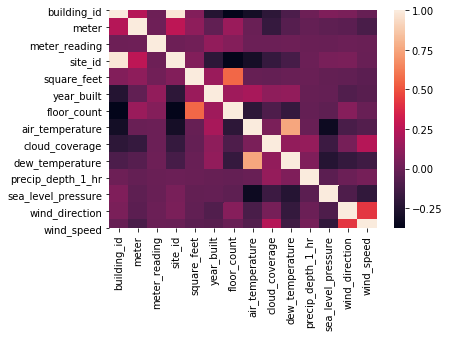

In [168]:
mat_coorr=train_m.corr()
sn.heatmap(mat_coorr)
plt.show()

Pas de corrélation particulière entre `meter_reading` et les autres variables. Il y a cependant quelques corrélations entre certaines variables comme `floor_count` et `square_feet` ou `air_temperature` et `dew_temperature`. nous les traiterons plus tard pour voir si ces corrélations ont une influence sur nos modèles. 

In [169]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

In [170]:
is_na=train_m.isnull().sum()*100/train_m.shape[0]
is_na=is_na.sort_values()
ind = np.arange(len(is_na))

In [171]:
from bokeh.models import HoverTool, Legend, LegendItem, Range1d, ColumnDataSource,  RangeTool,  Select, MultiSelect
from bokeh.transform import linear_cmap
from bokeh.palettes import RdYlGn11 as palette
from bokeh.models import LinearAxis
from bokeh.models import HoverTool, Legend, LegendItem, Range1d, ColumnDataSource,  RangeTool,  Select, MultiSelect

p = figure(width = 600, height = 300)
source = ColumnDataSource(data=dict(x=ind, y=is_na.values, xname = is_na.index.to_list()))

In [172]:
color_mapper = linear_cmap(palette=palette, low=0, high=100, field_name='y')

hist1 = p.vbar(x='x', top = 'y' , width=1,  source=source, line_color=color_mapper, fill_color = color_mapper, name = "Histogramme",alpha=0.6)

h = HoverTool( # code pour l'outil qui affiche les informations de la courbe en passant la souris dessus
    tooltips=[
        ('Variable', '@xname'),
        ('Pourcentage de NA', '$y'),#pour obtenir le nom de la courbe sur laquelle se trouve le pointeur
    ],
    renderers = [hist1]#, j]
)
p.add_tools(h)


show(p)

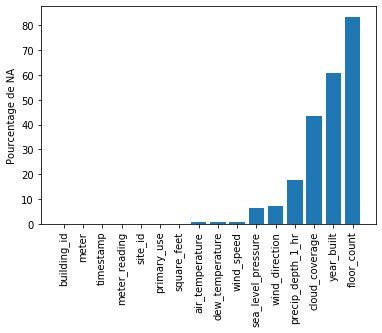

In [173]:
plt.bar(ind, is_na.values)
plt.xticks(ind,is_na.index,rotation=90)
plt.ylabel("Pourcentage de NA")
plt.show()

Les labels `floor_count` et `year_built` sont ceux pour lesquels il y a le plus de NA. C'est dommage car ce sont des indexs qui intuitivement auront beaucoup d'influence sur l'energie consommée.

In [174]:
train_m['hour_datetime'] = train_m['timestamp'].dt.hour.astype(np.int8)  
train_m['day_week'] = train_m['timestamp'].dt.dayofweek.astype(np.int8)

In [175]:
p2 = figure(width = 600, height = 300)
p3 = figure(width = 600, height = 300)#,x_axis_type = 'datetime')
# source2 = ColumnDataSource(data=dict(x=ind, y=is_na.values, xname = is_na.index.to_list()))
# p.line(df['Date'], df.vol.mul(df.vol), line_width = 3, name= 'données réelles', color = 'purple')
# p2.line(train_m.hour_datetime, train_m.meter_reading, line_width = 2, color='black', name = 'Par heure')
p2.line(train_m.groupby('hour_datetime').hour_datetime.mean(), train_m[['hour_datetime', 'meter_reading']].groupby('hour_datetime').meter_reading.mean(), line_width = 2, color='red', name = 'Meter reading par heure')

legend_list = []
for i in range(len(p2.renderers)):
        leg_tmp = LegendItem(label=p2.renderers[i].name, renderers = [p2.renderers[i]])
        legend_list.append(leg_tmp)
legend = Legend(items=legend_list, location='top_right')
p2.add_layout(legend)

show(p2)

p3.line(train_m.groupby('day_week').day_week.mean(), train_m[['day_week', 'meter_reading']].groupby('day_week').meter_reading.mean(), line_width = 2, color='red', name = 'Meter reading par jour')


legend_list = []
for i in range(len(p3.renderers)):
        leg_tmp = LegendItem(label=p3.renderers[i].name, renderers = [p3.renderers[i]])
        legend_list.append(leg_tmp)
legend = Legend(items=legend_list, location='top_right')
p3.add_layout(legend)




show(p3)

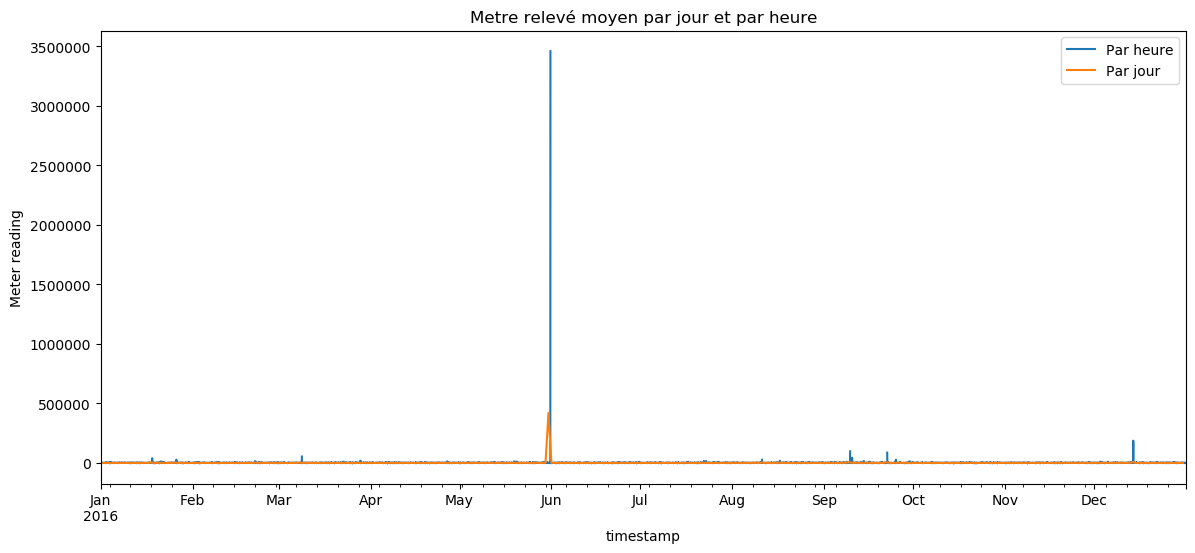

In [176]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6),dpi=100)
train_m[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='Par heure').set_ylabel('Meter reading');
train_m[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='Par jour').set_ylabel('Meter reading');
axes.set_title('Metre relevé moyen par jour et par heure');
axes.legend();
plt.show()

La forme de la distribution de la valeur cible dans le temps est plutôt étrange. On observe des pics irréguliers. Regardons de plus près.

In [177]:
import warnings
warnings.filterwarnings("ignore")

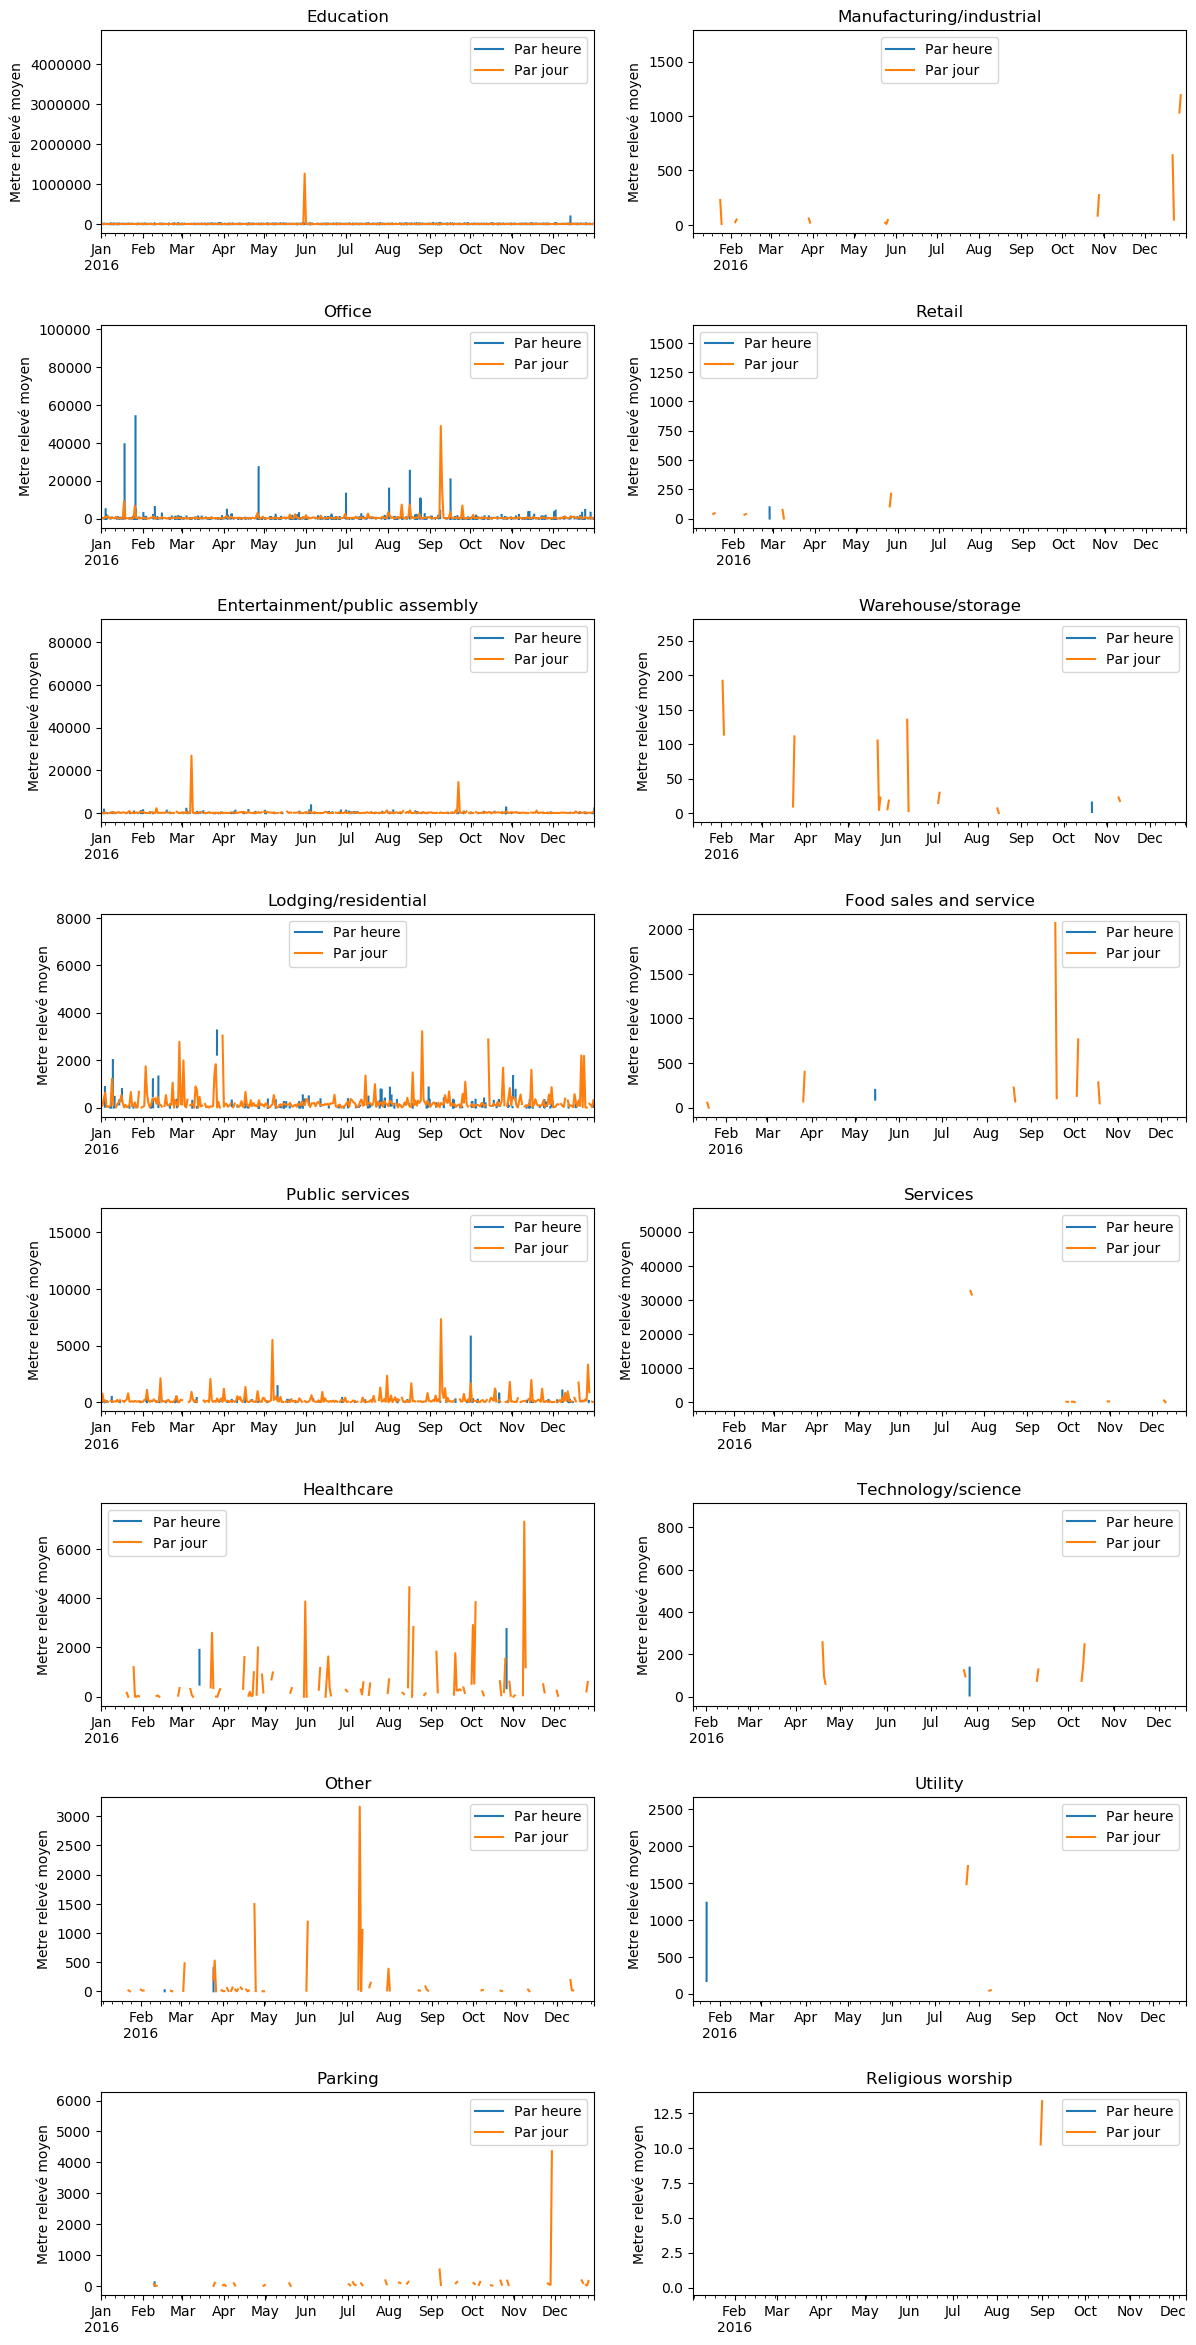

In [178]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
list_pu=list(train_m['primary_use'].value_counts().index);
for i in range(len(list_pu)):
    train_m[train_m['primary_use'] == list_pu[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], label='Par heure').set_ylabel('Metre relevé moyen');
    train_m[train_m['primary_use'] == list_pu[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8],  label='Par jour').set_xlabel('');
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title(list_pu[i]);
    plt.subplots_adjust(hspace=0.45)
plt.show()

Notre problème se situe dans Education.

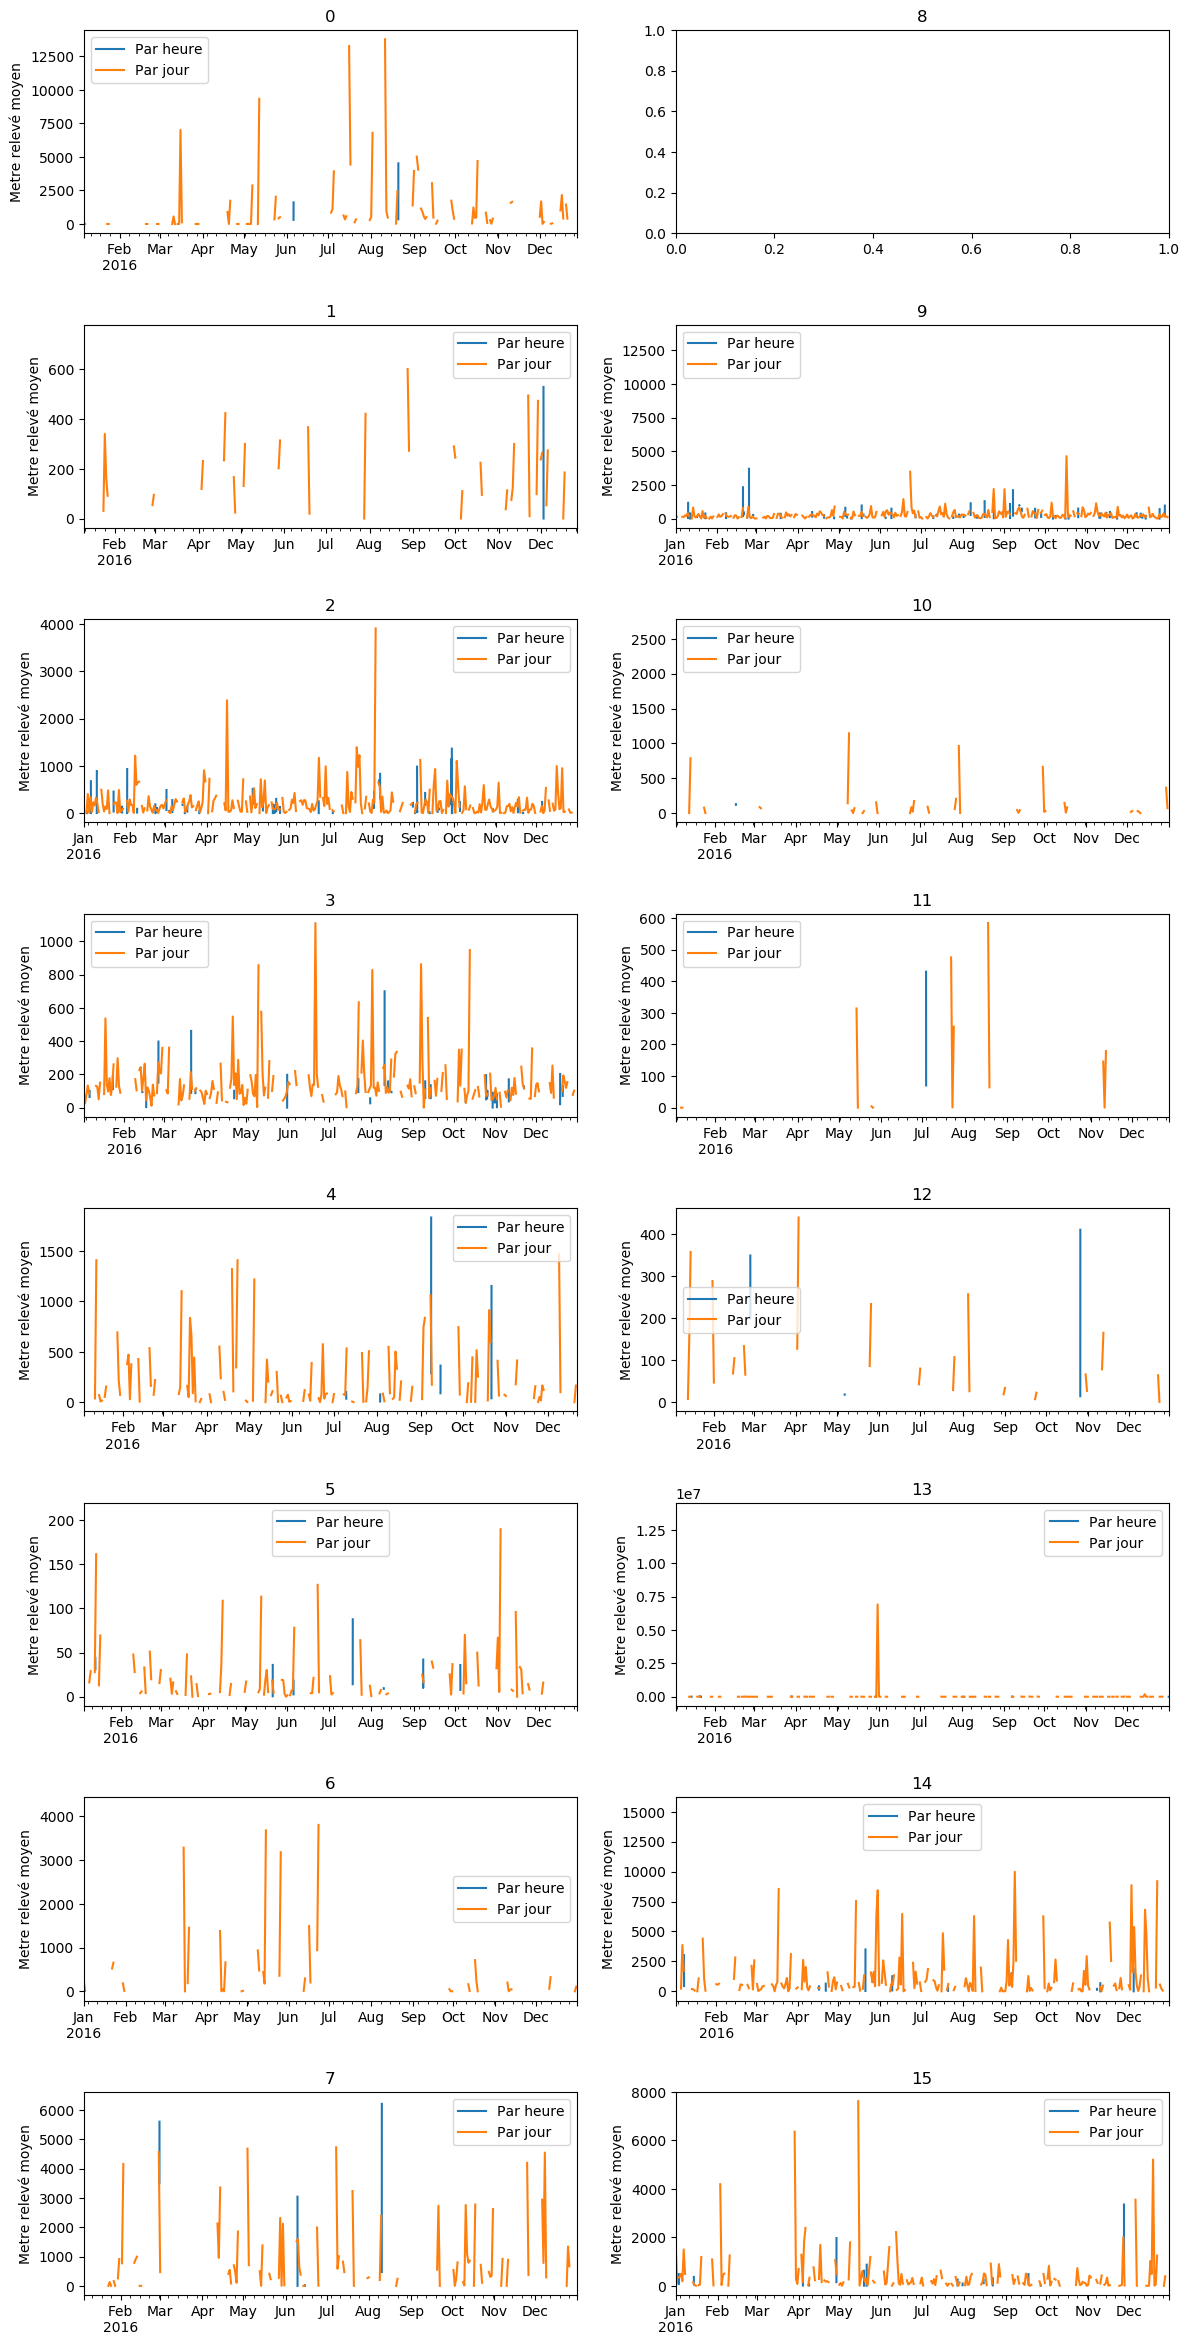

In [179]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
list_sid=list(train_m['site_id'].value_counts().index);
train_hist=train_m[train_m['primary_use'] == 'Education']
for i in range(len(list_sid)):
    try :
        train_hist[train_hist['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], label='Par heure').set_ylabel('Metre relevé moyen');
        train_hist[train_hist['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8],  label='Par jour').set_xlabel('');
        axes[i%8][i//8].legend();
    except :
        pass
    axes[i%8][i//8].set_title(i);
    plt.subplots_adjust(hspace=0.45)
plt.show()
del train_hist;

Notre problème se situe dans le 13.

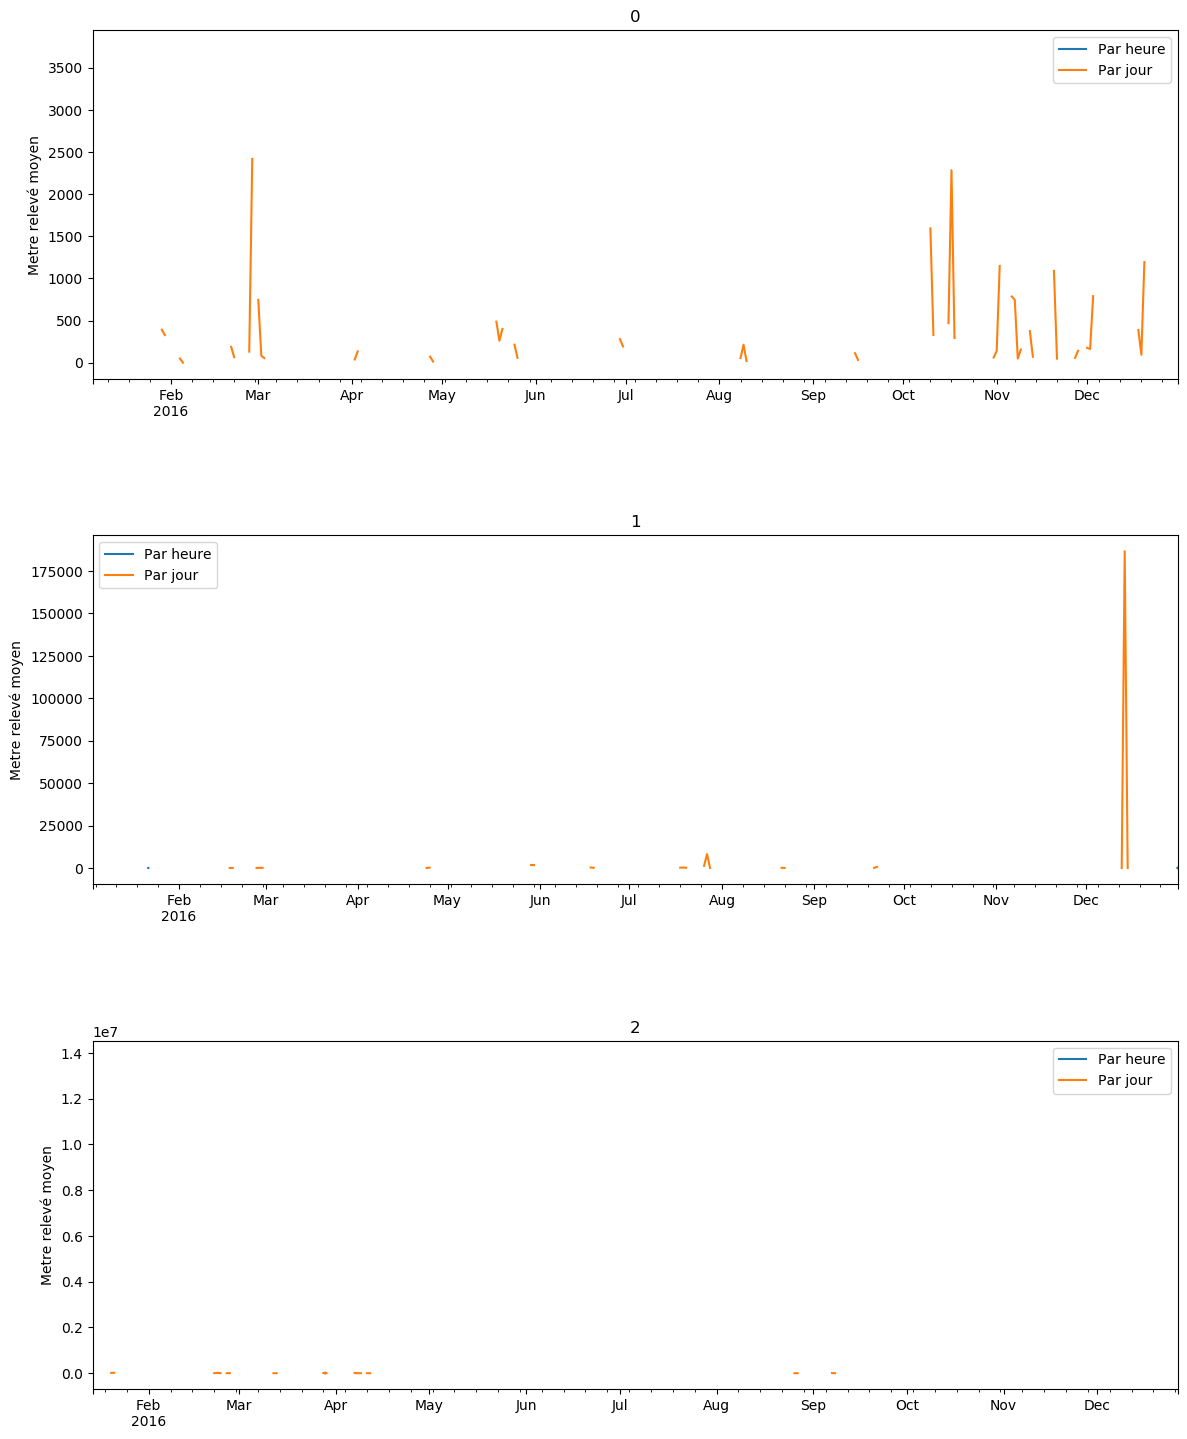

In [180]:
fig, axes = plt.subplots(3,1,figsize=(14, 18), dpi=100)
train_hist=train_m[train_m['primary_use'] == 'Education']
train_hist2=train_hist[train_hist['site_id'] == 13]
list_met=list(train_hist2['meter'].value_counts().index);
for i in range(len(list_met)):
    try :
        train_hist2[train_hist2['meter'] == list_met[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], label='Par heure').set_ylabel('Metre relevé moyen');
        train_hist2[train_hist2['meter'] == list_met[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i],  label='Par jour').set_xlabel('');
        axes[i].legend();
    except TypeError:
        pass
    axes[i].set_title(list_met[i]);
    plt.subplots_adjust(hspace=0.45)
plt.show()
del train_hist;
del train_hist2;

Le problème se situe dans le metre de type 2.

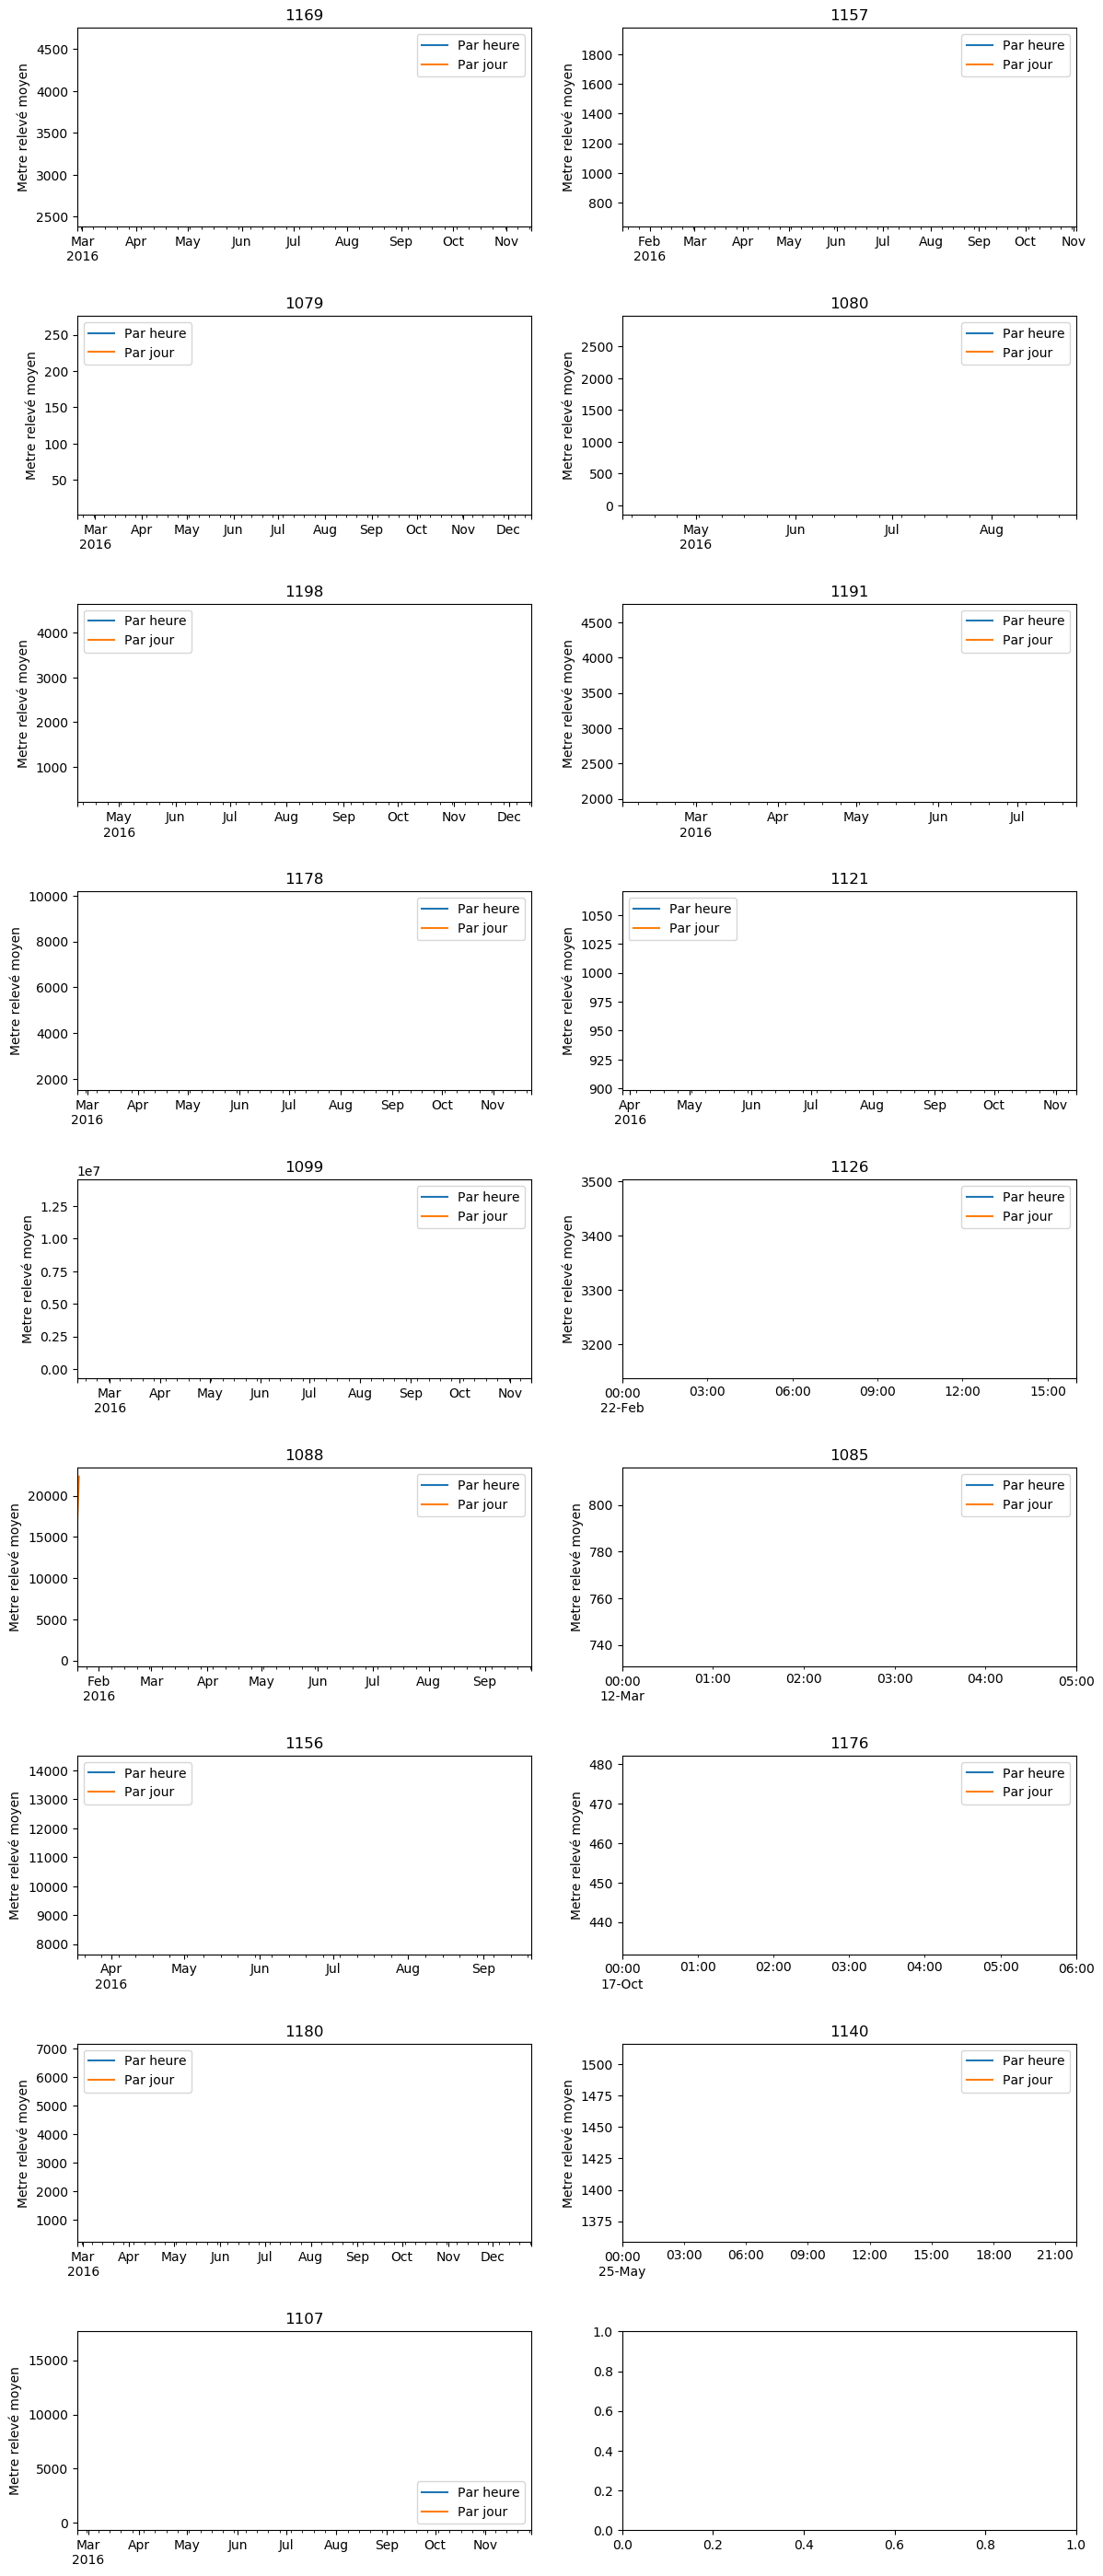

In [181]:
fig, axes = plt.subplots(9,2,figsize=(14, 36), dpi=100)
train_hist=train_m[train_m['primary_use'] == 'Education']
train_hist2=train_hist[train_hist['site_id'] == 13]
train_hist3=train_hist2[train_hist2['meter']==2]
list_build=list(train_hist3['building_id'].value_counts().index);
for i in range(len(list_build)):
    try :
        train_hist3[train_hist3['building_id'] == list_build[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%9][i//9], label='Par heure').set_ylabel('Metre relevé moyen');
        train_hist3[train_hist3['building_id'] == list_build[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%9][i//9],  label='Par jour').set_xlabel('');
        axes[i%9][i//9].legend();
    except TypeError:
        pass
    axes[i%9][i//9].set_title(list_build[i]);
    plt.subplots_adjust(hspace=0.45)
plt.show()
del train_hist;
del train_hist2;
del train_hist3;

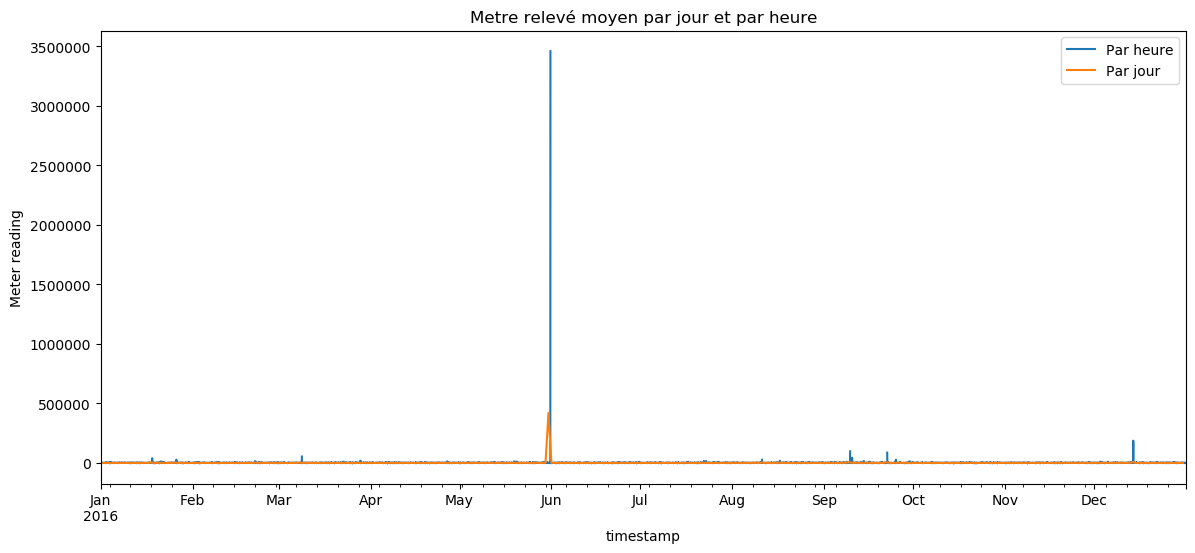

In [182]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6),dpi=100)
train_m[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='Par heure').set_ylabel('Meter reading');
train_m[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='Par jour').set_ylabel('Meter reading');
axes.set_title('Metre relevé moyen par jour et par heure');
axes.legend();
plt.show()

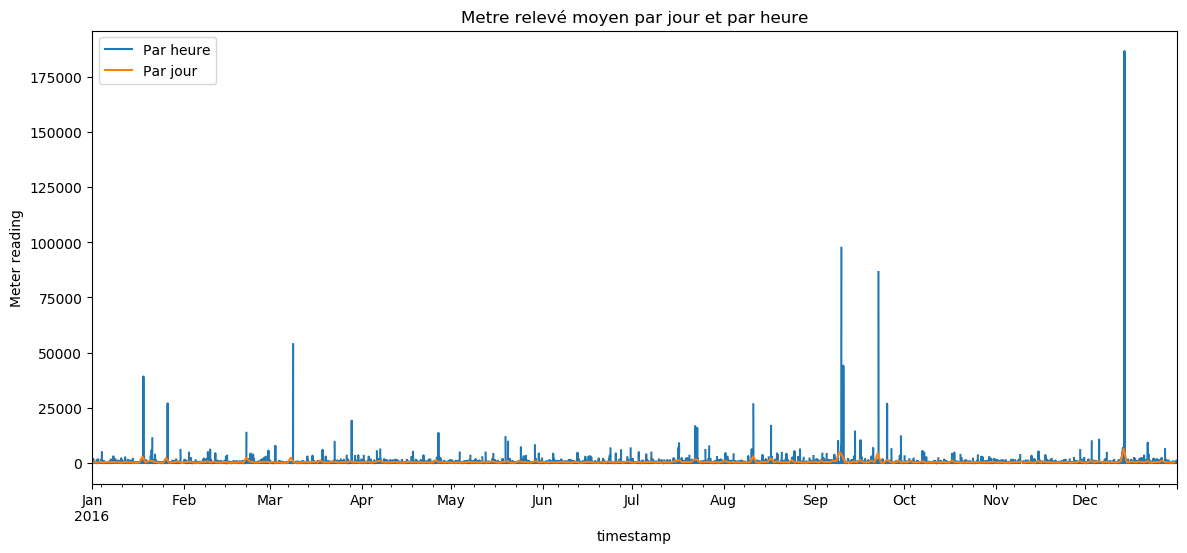

In [183]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6),dpi=100)
new_train=train_m[train_m['building_id'] != 1099]
new_train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='Par heure').set_ylabel('Meter reading');
new_train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='Par jour').set_ylabel('Meter reading');
axes.set_title('Metre relevé moyen par jour et par heure');
axes.legend();
plt.show()

In [184]:
new_test=test_m
new_test

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,33239792,1233,1,2017-06-07 04:00:00,14,Education,43143,NaN,NaN,12.203125,NaN,11.101562,0.0,1012.0,100.0,4.101562
1,27626124,1162,0,2017-04-30 10:00:00,13,Office,72958,NaN,NaN,7.199219,NaN,-4.398438,0.0,1019.5,70.0,5.101562
2,35946102,1224,3,2018-07-03 18:00:00,14,Office,23481,NaN,NaN,35.000000,0.0,24.406250,0.0,1020.5,NaN,2.099609
3,14226631,630,0,2018-04-10 15:00:00,4,Education,93420,1948.0,5.0,13.296875,NaN,10.601562,0.0,1018.5,290.0,2.099609
4,15724965,730,0,2018-03-07 21:00:00,5,Education,126045,1966.0,4.0,4.000000,NaN,3.000000,NaN,NaN,NaN,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20844,22100181,961,2,2017-11-29 01:00:00,9,Education,155882,NaN,NaN,22.203125,0.0,11.101562,0.0,1017.0,130.0,2.599609
20845,27416484,1093,1,2017-04-02 04:00:00,13,Office,47578,NaN,NaN,12.203125,2.0,0.600098,NaN,1020.0,240.0,2.099609
20846,30989622,1177,1,2018-07-28 00:00:00,13,Office,20444,NaN,NaN,25.000000,2.0,10.000000,0.0,1018.0,330.0,3.599609
20847,12080704,527,0,2018-07-12 21:00:00,3,Public services,9392,NaN,NaN,32.812500,4.0,12.796875,0.0,1020.5,50.0,3.099609


In [185]:
del train_m
del test_m

Remplacement NA

In [186]:
for i in list_pu:
    print(i)
    print(new_train[new_train['primary_use']==i].isnull().sum()*100/new_train[new_train['primary_use']==i].shape[0])
    print("")

Education
building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            51.210565
floor_count           78.258743
air_temperature        0.733676
cloud_coverage        44.583028
dew_temperature        0.733676
precip_depth_1_hr     23.012962
sea_level_pressure     7.630227
wind_direction         8.632918
wind_speed             1.124969
hour_datetime          0.000000
day_week               0.000000
dtype: float64

Office
building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            76.819030
floor_count           91.930970
air_temperature        0.513060
cloud_coverage        43.703358
dew_temperature        0.513060
precip_

`Services`, `Food sales and service`, `Religious worship` n'ont aucune donnée pour la variable `floor_count`. Nous allons d'abord combler ce qu'il manque dans les autres catégories par la moyenne. 

In [187]:
new_train.isnull().sum()*100/new_train.shape[0]

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            60.916922
floor_count           83.453807
air_temperature        0.604020
cloud_coverage        43.657788
dew_temperature        0.613922
precip_depth_1_hr     17.724527
sea_level_pressure     6.198634
wind_direction         7.139321
wind_speed             0.891177
hour_datetime          0.000000
day_week               0.000000
dtype: float64

In [188]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                 0.000000
building_id            0.000000
meter                  0.000000
timestamp              0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            58.679073
floor_count           82.804931
air_temperature        0.532400
cloud_coverage        46.736054
dew_temperature        0.613938
precip_depth_1_hr     18.739508
sea_level_pressure     5.966713
wind_direction         7.362463
wind_speed             0.714663
dtype: float64

In [189]:
import statistics
list_pu_mean=[]
list_pu_mean_test=[]
for i in list_pu:
    temp=new_train[new_train['primary_use']==i]['floor_count'].dropna()
    if (len(temp)>0):
        list_pu_mean.append(statistics.mean(temp))
    else :
        list_pu_mean.append(0)
        
for i in list_pu:
    temp=new_test[new_test['primary_use']==i]['floor_count'].dropna()
    if (len(temp)>0):
        list_pu_mean_test.append(statistics.mean(temp))
    else :
        list_pu_mean_test.append(0)        


In [190]:
for i in range(len(list_pu)):
    if (list_pu[i]!="Services") & (list_pu[i]!="Food sales and service") & (list_pu[i]!="Religious worship") :
        new_train.loc[new_train.primary_use==list_pu[i],['floor_count']]=new_train[new_train['primary_use']==list_pu[i]]['floor_count'].fillna(list_pu_mean[i])
        new_test.loc[new_test.primary_use==list_pu[i],['floor_count']]=new_test[new_test['primary_use']==list_pu[i]]['floor_count'].fillna(list_pu_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour_datetime,day_week
0,98,1,2016-11-28 03:00:00,1646.199951,0,Lodging/residential,200933,2007.0,6.769531,18.296875,NaN,12.796875,0.0,1019.5,80.0,2.599609,3,0
1,1255,0,2016-12-27 09:00:00,47.010399,14,Office,23702,NaN,3.958984,12.203125,NaN,8.898438,0.0,1014.0,220.0,8.203125,9,1
2,1299,2,2016-04-10 10:00:00,621.132019,14,Education,25401,NaN,5.234375,-1.099609,0.0,-10.601562,0.0,1024.0,300.0,2.599609,10,6
3,197,0,2016-04-03 17:00:00,113.820000,2,Public services,102856,NaN,2.376953,24.406250,0.0,-6.101562,0.0,1017.5,90.0,5.101562,17,6
4,389,0,2016-05-06 07:00:00,61.200001,3,Education,57165,2014.0,5.234375,12.203125,NaN,9.398438,0.0,1004.5,350.0,5.101562,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10103,170,1,2016-01-11 02:00:00,8.440400,2,Retail,45224,1982.0,1.400391,12.203125,NaN,4.398438,0.0,1019.5,250.0,2.099609,2,0
10104,1111,2,2016-03-04 22:00:00,434.570007,13,Office,67839,NaN,3.958984,0.600098,NaN,-2.199219,-1.0,1015.0,190.0,3.099609,22,4
10105,415,0,2016-01-12 03:00:00,20.389999,3,Education,41329,NaN,5.234375,-1.099609,4.0,-11.703125,0.0,1020.5,350.0,2.099609,3,1
10106,1076,0,2016-02-09 08:00:00,100.779999,13,Lodging/residential,117054,NaN,6.769531,-11.703125,NaN,-16.703125,-1.0,1017.5,330.0,6.199219,8,1


In [191]:
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['floor_count'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['floor_count'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

In [192]:
for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['floor_count']]=new_train[new_train['site_id']==list_sid[i]]['floor_count'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['floor_count']]=new_test[new_test['site_id']==list_sid[i]]['floor_count'].fillna(list_sid_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour_datetime,day_week
0,98,1,2016-11-28 03:00:00,1646.199951,0,Lodging/residential,200933,2007.0,6.769531,18.296875,NaN,12.796875,0.0,1019.5,80.0,2.599609,3,0
1,1255,0,2016-12-27 09:00:00,47.010399,14,Office,23702,NaN,3.958984,12.203125,NaN,8.898438,0.0,1014.0,220.0,8.203125,9,1
2,1299,2,2016-04-10 10:00:00,621.132019,14,Education,25401,NaN,5.234375,-1.099609,0.0,-10.601562,0.0,1024.0,300.0,2.599609,10,6
3,197,0,2016-04-03 17:00:00,113.820000,2,Public services,102856,NaN,2.376953,24.406250,0.0,-6.101562,0.0,1017.5,90.0,5.101562,17,6
4,389,0,2016-05-06 07:00:00,61.200001,3,Education,57165,2014.0,5.234375,12.203125,NaN,9.398438,0.0,1004.5,350.0,5.101562,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10103,170,1,2016-01-11 02:00:00,8.440400,2,Retail,45224,1982.0,1.400391,12.203125,NaN,4.398438,0.0,1019.5,250.0,2.099609,2,0
10104,1111,2,2016-03-04 22:00:00,434.570007,13,Office,67839,NaN,3.958984,0.600098,NaN,-2.199219,-1.0,1015.0,190.0,3.099609,22,4
10105,415,0,2016-01-12 03:00:00,20.389999,3,Education,41329,NaN,5.234375,-1.099609,4.0,-11.703125,0.0,1020.5,350.0,2.099609,3,1
10106,1076,0,2016-02-09 08:00:00,100.779999,13,Lodging/residential,117054,NaN,6.769531,-11.703125,NaN,-16.703125,-1.0,1017.5,330.0,6.199219,8,1


In [193]:
new_train.isnull().sum()*100/new_train.shape[0]

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            60.916922
floor_count            0.000000
air_temperature        0.604020
cloud_coverage        43.657788
dew_temperature        0.613922
precip_depth_1_hr     17.724527
sea_level_pressure     6.198634
wind_direction         7.139321
wind_speed             0.891177
hour_datetime          0.000000
day_week               0.000000
dtype: float64

In [194]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                 0.000000
building_id            0.000000
meter                  0.000000
timestamp              0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            58.679073
floor_count            0.000000
air_temperature        0.532400
cloud_coverage        46.736054
dew_temperature        0.613938
precip_depth_1_hr     18.739508
sea_level_pressure     5.966713
wind_direction         7.362463
wind_speed             0.714663
dtype: float64

C'est bon pour `floor_count`, au tour de `year_built`

In [195]:
list_pu_mean=[]
list_pu_mean_test=[]
for i in list_pu:
    temp=new_train[new_train['primary_use']==i]['year_built'].dropna()
    if (len(temp)>0):
        list_pu_mean.append(statistics.mean(temp))
    else :
        list_pu_mean.append(0)
        
for i in list_pu:
    temp=new_test[new_test['primary_use']==i]['year_built'].dropna()
    if (len(temp)>0):
        list_pu_mean_test.append(statistics.mean(temp))
    else :
        list_pu_mean_test.append(0)

In [196]:
for i in range(len(list_pu)):
    if list_pu[i]!="Services":
        new_train.loc[new_train.primary_use==list_pu[i],['year_built']]=new_train[new_train['primary_use']==list_pu[i]]['year_built'].fillna(list_pu_mean[i])
        new_test.loc[new_test.primary_use==list_pu[i],['year_built']]=new_test[new_test['primary_use']==list_pu[i]]['year_built'].fillna(list_pu_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour_datetime,day_week
0,98,1,2016-11-28 03:00:00,1646.199951,0,Lodging/residential,200933,2007.0,6.769531,18.296875,NaN,12.796875,0.0,1019.5,80.0,2.599609,3,0
1,1255,0,2016-12-27 09:00:00,47.010399,14,Office,23702,1968.0,3.958984,12.203125,NaN,8.898438,0.0,1014.0,220.0,8.203125,9,1
2,1299,2,2016-04-10 10:00:00,621.132019,14,Education,25401,1965.0,5.234375,-1.099609,0.0,-10.601562,0.0,1024.0,300.0,2.599609,10,6
3,197,0,2016-04-03 17:00:00,113.820000,2,Public services,102856,1963.0,2.376953,24.406250,0.0,-6.101562,0.0,1017.5,90.0,5.101562,17,6
4,389,0,2016-05-06 07:00:00,61.200001,3,Education,57165,2014.0,5.234375,12.203125,NaN,9.398438,0.0,1004.5,350.0,5.101562,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10103,170,1,2016-01-11 02:00:00,8.440400,2,Retail,45224,1982.0,1.400391,12.203125,NaN,4.398438,0.0,1019.5,250.0,2.099609,2,0
10104,1111,2,2016-03-04 22:00:00,434.570007,13,Office,67839,1968.0,3.958984,0.600098,NaN,-2.199219,-1.0,1015.0,190.0,3.099609,22,4
10105,415,0,2016-01-12 03:00:00,20.389999,3,Education,41329,1965.0,5.234375,-1.099609,4.0,-11.703125,0.0,1020.5,350.0,2.099609,3,1
10106,1076,0,2016-02-09 08:00:00,100.779999,13,Lodging/residential,117054,1972.0,6.769531,-11.703125,NaN,-16.703125,-1.0,1017.5,330.0,6.199219,8,1


In [197]:
new_train.isnull().sum()*100/new_train.shape[0]

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.425785
floor_count            0.000000
air_temperature        0.604020
cloud_coverage        43.657788
dew_temperature        0.613922
precip_depth_1_hr     17.724527
sea_level_pressure     6.198634
wind_direction         7.139321
wind_speed             0.891177
hour_datetime          0.000000
day_week               0.000000
dtype: float64

In [198]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                 0.000000
building_id            0.000000
meter                  0.000000
timestamp              0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.422083
floor_count            0.000000
air_temperature        0.532400
cloud_coverage        46.736054
dew_temperature        0.613938
precip_depth_1_hr     18.739508
sea_level_pressure     5.966713
wind_direction         7.362463
wind_speed             0.714663
dtype: float64

In [199]:
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['year_built'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['year_built'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

In [200]:
for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['year_built']]=new_train[new_train['site_id']==list_sid[i]]['year_built'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['year_built']]=new_test[new_test['site_id']==list_sid[i]]['year_built'].fillna(list_sid_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour_datetime,day_week
0,98,1,2016-11-28 03:00:00,1646.199951,0,Lodging/residential,200933,2007.0,6.769531,18.296875,NaN,12.796875,0.0,1019.5,80.0,2.599609,3,0
1,1255,0,2016-12-27 09:00:00,47.010399,14,Office,23702,1968.0,3.958984,12.203125,NaN,8.898438,0.0,1014.0,220.0,8.203125,9,1
2,1299,2,2016-04-10 10:00:00,621.132019,14,Education,25401,1965.0,5.234375,-1.099609,0.0,-10.601562,0.0,1024.0,300.0,2.599609,10,6
3,197,0,2016-04-03 17:00:00,113.820000,2,Public services,102856,1963.0,2.376953,24.406250,0.0,-6.101562,0.0,1017.5,90.0,5.101562,17,6
4,389,0,2016-05-06 07:00:00,61.200001,3,Education,57165,2014.0,5.234375,12.203125,NaN,9.398438,0.0,1004.5,350.0,5.101562,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10103,170,1,2016-01-11 02:00:00,8.440400,2,Retail,45224,1982.0,1.400391,12.203125,NaN,4.398438,0.0,1019.5,250.0,2.099609,2,0
10104,1111,2,2016-03-04 22:00:00,434.570007,13,Office,67839,1968.0,3.958984,0.600098,NaN,-2.199219,-1.0,1015.0,190.0,3.099609,22,4
10105,415,0,2016-01-12 03:00:00,20.389999,3,Education,41329,1965.0,5.234375,-1.099609,4.0,-11.703125,0.0,1020.5,350.0,2.099609,3,1
10106,1076,0,2016-02-09 08:00:00,100.779999,13,Lodging/residential,117054,1972.0,6.769531,-11.703125,NaN,-16.703125,-1.0,1017.5,330.0,6.199219,8,1


In [201]:
new_train.isnull().sum()*100/new_train.shape[0]

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.604020
cloud_coverage        43.657788
dew_temperature        0.613922
precip_depth_1_hr     17.724527
sea_level_pressure     6.198634
wind_direction         7.139321
wind_speed             0.891177
hour_datetime          0.000000
day_week               0.000000
dtype: float64

In [202]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                 0.000000
building_id            0.000000
meter                  0.000000
timestamp              0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.532400
cloud_coverage        46.736054
dew_temperature        0.613938
precip_depth_1_hr     18.739508
sea_level_pressure     5.966713
wind_direction         7.362463
wind_speed             0.714663
dtype: float64

Pour les infos météo, on se base seulement selon le site. Se baser sur `primary_use` n'aurait pas de sens pour ce type de donnée.

In [203]:
for i in list_sid:
    print(i)
    print(new_train[new_train['site_id']==i].isnull().sum()*100/new_train[new_train['site_id']==i].shape[0])
    print("")

9
building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.288392
cloud_coverage        41.167988
dew_temperature        0.288392
precip_depth_1_hr      0.216294
sea_level_pressure     3.172314
wind_direction        27.901947
wind_speed             1.730353
hour_datetime          0.000000
day_week               0.000000
dtype: float64

13
building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.000000
cloud_coverage        49.205148
dew_temperature        0.000000
precip_depth_1_hr  

In [204]:
#cloud coverage
#site id 7, 11 n'ont aucune donnée

list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['cloud_coverage'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['cloud_coverage'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    if (list_sid[i] != 7) & (list_sid[i] != 11):
        new_train.loc[new_train.site_id==list_sid[i],['cloud_coverage']]=new_train[new_train['site_id']==list_sid[i]]['cloud_coverage'].fillna(list_sid_mean[i])
        new_test.loc[new_test.site_id==list_sid[i],['cloud_coverage']]=new_test[new_test['site_id']==list_sid[i]]['cloud_coverage'].fillna(list_sid_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour_datetime,day_week
0,98,1,2016-11-28 03:00:00,1646.199951,0,Lodging/residential,200933,2007.0,6.769531,18.296875,3.263672,12.796875,0.0,1019.5,80.0,2.599609,3,0
1,1255,0,2016-12-27 09:00:00,47.010399,14,Office,23702,1968.0,3.958984,12.203125,0.513184,8.898438,0.0,1014.0,220.0,8.203125,9,1
2,1299,2,2016-04-10 10:00:00,621.132019,14,Education,25401,1965.0,5.234375,-1.099609,0.000000,-10.601562,0.0,1024.0,300.0,2.599609,10,6
3,197,0,2016-04-03 17:00:00,113.820000,2,Public services,102856,1963.0,2.376953,24.406250,0.000000,-6.101562,0.0,1017.5,90.0,5.101562,17,6
4,389,0,2016-05-06 07:00:00,61.200001,3,Education,57165,2014.0,5.234375,12.203125,3.615234,9.398438,0.0,1004.5,350.0,5.101562,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10103,170,1,2016-01-11 02:00:00,8.440400,2,Retail,45224,1982.0,1.400391,12.203125,2.060547,4.398438,0.0,1019.5,250.0,2.099609,2,0
10104,1111,2,2016-03-04 22:00:00,434.570007,13,Office,67839,1968.0,3.958984,0.600098,2.933594,-2.199219,-1.0,1015.0,190.0,3.099609,22,4
10105,415,0,2016-01-12 03:00:00,20.389999,3,Education,41329,1965.0,5.234375,-1.099609,4.000000,-11.703125,0.0,1020.5,350.0,2.099609,3,1
10106,1076,0,2016-02-09 08:00:00,100.779999,13,Lodging/residential,117054,1972.0,6.769531,-11.703125,2.933594,-16.703125,-1.0,1017.5,330.0,6.199219,8,1


In [205]:
new_train.isnull().sum()*100/new_train.shape[0] #il reste 2% de cloud_coverage inconnu

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.604020
cloud_coverage         2.317061
dew_temperature        0.613922
precip_depth_1_hr     17.724527
sea_level_pressure     6.198634
wind_direction         7.139321
wind_speed             0.891177
hour_datetime          0.000000
day_week               0.000000
dtype: float64

In [206]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                 0.000000
building_id            0.000000
meter                  0.000000
timestamp              0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.532400
cloud_coverage         2.350233
dew_temperature        0.613938
precip_depth_1_hr     18.739508
sea_level_pressure     5.966713
wind_direction         7.362463
wind_speed             0.714663
dtype: float64

In [207]:
#precip_depth_1_hr
#12, 5, 1 n'ont pas de donnée

list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['precip_depth_1_hr'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)

for i in list_sid:
    temp=new_test[new_test['site_id']==i]['precip_depth_1_hr'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)
        
for i in range(len(list_sid)):
    if (list_sid[i] != 12) & (list_sid[i] != 5) & (list_sid[i] != 1):
        new_train.loc[new_train.site_id==list_sid[i],['precip_depth_1_hr']]=new_train[new_train['site_id']==list_sid[i]]['precip_depth_1_hr'].fillna(list_sid_mean[i])
        new_test.loc[new_test.site_id==list_sid[i],['precip_depth_1_hr']]=new_test[new_test['site_id']==list_sid[i]]['precip_depth_1_hr'].fillna(list_sid_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour_datetime,day_week
0,98,1,2016-11-28 03:00:00,1646.199951,0,Lodging/residential,200933,2007.0,6.769531,18.296875,3.263672,12.796875,0.0,1019.5,80.0,2.599609,3,0
1,1255,0,2016-12-27 09:00:00,47.010399,14,Office,23702,1968.0,3.958984,12.203125,0.513184,8.898438,0.0,1014.0,220.0,8.203125,9,1
2,1299,2,2016-04-10 10:00:00,621.132019,14,Education,25401,1965.0,5.234375,-1.099609,0.000000,-10.601562,0.0,1024.0,300.0,2.599609,10,6
3,197,0,2016-04-03 17:00:00,113.820000,2,Public services,102856,1963.0,2.376953,24.406250,0.000000,-6.101562,0.0,1017.5,90.0,5.101562,17,6
4,389,0,2016-05-06 07:00:00,61.200001,3,Education,57165,2014.0,5.234375,12.203125,3.615234,9.398438,0.0,1004.5,350.0,5.101562,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10103,170,1,2016-01-11 02:00:00,8.440400,2,Retail,45224,1982.0,1.400391,12.203125,2.060547,4.398438,0.0,1019.5,250.0,2.099609,2,0
10104,1111,2,2016-03-04 22:00:00,434.570007,13,Office,67839,1968.0,3.958984,0.600098,2.933594,-2.199219,-1.0,1015.0,190.0,3.099609,22,4
10105,415,0,2016-01-12 03:00:00,20.389999,3,Education,41329,1965.0,5.234375,-1.099609,4.000000,-11.703125,0.0,1020.5,350.0,2.099609,3,1
10106,1076,0,2016-02-09 08:00:00,100.779999,13,Lodging/residential,117054,1972.0,6.769531,-11.703125,2.933594,-16.703125,-1.0,1017.5,330.0,6.199219,8,1


In [208]:
new_train.isnull().sum()*100/new_train.shape[0] #il reste 8% d'inconnu pour precip_depth_1_hr

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.604020
cloud_coverage        2.317061
dew_temperature       0.613922
precip_depth_1_hr     8.020596
sea_level_pressure    6.198634
wind_direction        7.139321
wind_speed            0.891177
hour_datetime         0.000000
day_week              0.000000
dtype: float64

In [209]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                0.000000
building_id           0.000000
meter                 0.000000
timestamp             0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.532400
cloud_coverage        2.350233
dew_temperature       0.613938
precip_depth_1_hr     7.832510
sea_level_pressure    5.966713
wind_direction        7.362463
wind_speed            0.714663
dtype: float64

In [210]:
#sea_lever_pressure
#le site 5 n'a aucune donnée

list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['sea_level_pressure'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['sea_level_pressure'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    if list_sid[i] != 5:
        new_train.loc[new_train.site_id==list_sid[i],['sea_level_pressure']]=new_train[new_train['site_id']==list_sid[i]]['sea_level_pressure'].fillna(list_sid_mean[i])
        new_test.loc[new_test.site_id==list_sid[i],['sea_level_pressure']]=new_test[new_test['site_id']==list_sid[i]]['sea_level_pressure'].fillna(list_sid_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour_datetime,day_week
0,98,1,2016-11-28 03:00:00,1646.199951,0,Lodging/residential,200933,2007.0,6.769531,18.296875,3.263672,12.796875,0.0,1019.5,80.0,2.599609,3,0
1,1255,0,2016-12-27 09:00:00,47.010399,14,Office,23702,1968.0,3.958984,12.203125,0.513184,8.898438,0.0,1014.0,220.0,8.203125,9,1
2,1299,2,2016-04-10 10:00:00,621.132019,14,Education,25401,1965.0,5.234375,-1.099609,0.000000,-10.601562,0.0,1024.0,300.0,2.599609,10,6
3,197,0,2016-04-03 17:00:00,113.820000,2,Public services,102856,1963.0,2.376953,24.406250,0.000000,-6.101562,0.0,1017.5,90.0,5.101562,17,6
4,389,0,2016-05-06 07:00:00,61.200001,3,Education,57165,2014.0,5.234375,12.203125,3.615234,9.398438,0.0,1004.5,350.0,5.101562,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10103,170,1,2016-01-11 02:00:00,8.440400,2,Retail,45224,1982.0,1.400391,12.203125,2.060547,4.398438,0.0,1019.5,250.0,2.099609,2,0
10104,1111,2,2016-03-04 22:00:00,434.570007,13,Office,67839,1968.0,3.958984,0.600098,2.933594,-2.199219,-1.0,1015.0,190.0,3.099609,22,4
10105,415,0,2016-01-12 03:00:00,20.389999,3,Education,41329,1965.0,5.234375,-1.099609,4.000000,-11.703125,0.0,1020.5,350.0,2.099609,3,1
10106,1076,0,2016-02-09 08:00:00,100.779999,13,Lodging/residential,117054,1972.0,6.769531,-11.703125,2.933594,-16.703125,-1.0,1017.5,330.0,6.199219,8,1


In [211]:
new_train.isnull().sum()*100/new_train.shape[0] #il reste 3.8% d'inconnu pour sea_level_pressure

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.604020
cloud_coverage        2.317061
dew_temperature       0.613922
precip_depth_1_hr     8.020596
sea_level_pressure    3.772651
wind_direction        7.139321
wind_speed            0.891177
hour_datetime         0.000000
day_week              0.000000
dtype: float64

In [212]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                0.000000
building_id           0.000000
meter                 0.000000
timestamp             0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.532400
cloud_coverage        2.350233
dew_temperature       0.613938
precip_depth_1_hr     7.832510
sea_level_pressure    3.650055
wind_direction        7.362463
wind_speed            0.714663
dtype: float64

In [213]:
#air_temperature
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['air_temperature'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['air_temperature'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['air_temperature']]=new_train[new_train['site_id']==list_sid[i]]['air_temperature'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['air_temperature']]=new_test[new_test['site_id']==list_sid[i]]['air_temperature'].fillna(list_sid_mean_test[i])
new_train.isnull().sum()*100/new_train.shape[0]

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.000000
cloud_coverage        2.317061
dew_temperature       0.613922
precip_depth_1_hr     8.020596
sea_level_pressure    3.772651
wind_direction        7.139321
wind_speed            0.891177
hour_datetime         0.000000
day_week              0.000000
dtype: float64

In [214]:
#dew_temperature
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['dew_temperature'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['dew_temperature'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['dew_temperature']]=new_train[new_train['site_id']==list_sid[i]]['dew_temperature'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['dew_temperature']]=new_test[new_test['site_id']==list_sid[i]]['dew_temperature'].fillna(list_sid_mean_test[i])

new_train.isnull().sum()*100/new_train.shape[0]

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.000000
cloud_coverage        2.317061
dew_temperature       0.000000
precip_depth_1_hr     8.020596
sea_level_pressure    3.772651
wind_direction        7.139321
wind_speed            0.891177
hour_datetime         0.000000
day_week              0.000000
dtype: float64

In [215]:
#wind_direction
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['wind_direction'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)

for i in list_sid:
    temp=new_test[new_test['site_id']==i]['wind_direction'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['wind_direction']]=new_train[new_train['site_id']==list_sid[i]]['wind_direction'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['wind_direction']]=new_test[new_test['site_id']==list_sid[i]]['wind_direction'].fillna(list_sid_mean_test[i])

new_train.isnull().sum()*100/new_train.shape[0]

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.000000
cloud_coverage        2.317061
dew_temperature       0.000000
precip_depth_1_hr     8.020596
sea_level_pressure    3.772651
wind_direction        0.000000
wind_speed            0.891177
hour_datetime         0.000000
day_week              0.000000
dtype: float64

In [216]:
#wind_speed
list_sid_mean=[]
list_sid_mean_test=[]

for i in list_sid:
    temp=new_train[new_train['site_id']==i]['wind_speed'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['wind_speed'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['wind_speed']]=new_train[new_train['site_id']==list_sid[i]]['wind_speed'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['wind_speed']]=new_test[new_test['site_id']==list_sid[i]]['wind_speed'].fillna(list_sid_mean_test[i])

new_train.isnull().sum()*100/new_train.shape[0]

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.000000
cloud_coverage        2.317061
dew_temperature       0.000000
precip_depth_1_hr     8.020596
sea_level_pressure    3.772651
wind_direction        0.000000
wind_speed            0.000000
hour_datetime         0.000000
day_week              0.000000
dtype: float64

In [217]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                0.000000
building_id           0.000000
meter                 0.000000
timestamp             0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.000000
cloud_coverage        2.350233
dew_temperature       0.000000
precip_depth_1_hr     7.832510
sea_level_pressure    3.650055
wind_direction        0.000000
wind_speed            0.000000
dtype: float64

Pour bien terminer le travail, et finir de remplir les derniers NA, il faudrait comparer les données météo pour retrouver les villes des différents sites et récupérer les données. On pourrait même remplacer les données moyennes ajoutées aux données météo par les valeurs réelles trouvées.

In [218]:
#FE
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

new_train['date'] = new_train.timestamp.dt.date
new_train ['heure'] = new_train.timestamp.dt.hour
new_train ['mois'] = new_train.timestamp.dt.month
new_train ['joursemaine'] = new_train.timestamp.dt.dayofweek

#cal = calendar()
#vac = cal.holidays(start=new_train.timestamp.min(), end=new_train.timestamp.max())
#new_train['EstVac'] = new_train['timestamp'].isin(vac)

new_test['date'] = new_test.timestamp.dt.date
new_test['heure'] = new_test.timestamp.dt.hour
new_test['mois'] = new_test.timestamp.dt.month
new_test['joursemaine'] = new_test.timestamp.dt.dayofweek

#cal = calendar()
#vac = cal.holidays(start=new_test.timestamp.min(), end=new_test.timestamp.max())
#new_test['EstVac'] = new_test['timestamp'].isin(vac)

In [219]:
new_train.primary_use = new_train.primary_use.astype('category')
new_test.primary_use = new_test.primary_use.astype('category')

In [220]:
train_df = new_train.dropna(axis='columns')


In [221]:
test_df=new_test.dropna(axis='columns')

In [222]:
test_df.shape

(20849, 17)

# <a id='6'>6. Model Training</a>

In [223]:
%%time
from sklearn.model_selection import GridSearchCV #, train_test_split,TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor

y_train = new_train['meter_reading']

# my_tree = DecisionTreeRegressor()

# MSE = make_scorer(mean_squared_error)

Wall time: 1.36 s


In [224]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_df['primary_use'])
train_df['primary_use']=le.transform(train_df['primary_use'])


In [225]:
test_df['primary_use']=le.transform(test_df['primary_use'])

In [226]:
train_df['date']=pd.to_numeric(pd.to_datetime(train_df['date']))

In [227]:
test_df['date']=pd.to_numeric(pd.to_datetime(test_df['date']))

In [228]:
train_df

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,dew_temperature,wind_direction,wind_speed,hour_datetime,day_week,date,heure,mois,joursemaine
0,98,1,2016-11-28 03:00:00,1646.199951,0,4,200933,2007.0,6.769531,18.296875,12.796875,80.0,2.599609,3,0,1480291200000000000,3,11,0
1,1255,0,2016-12-27 09:00:00,47.010399,14,6,23702,1968.0,3.958984,12.203125,8.898438,220.0,8.203125,9,1,1482796800000000000,9,12,1
2,1299,2,2016-04-10 10:00:00,621.132019,14,0,25401,1965.0,5.234375,-1.099609,-10.601562,300.0,2.599609,10,6,1460246400000000000,10,4,6
3,197,0,2016-04-03 17:00:00,113.820000,2,9,102856,1963.0,2.376953,24.406250,-6.101562,90.0,5.101562,17,6,1459641600000000000,17,4,6
4,389,0,2016-05-06 07:00:00,61.200001,3,0,57165,2014.0,5.234375,12.203125,9.398438,350.0,5.101562,7,4,1462492800000000000,7,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10103,170,1,2016-01-11 02:00:00,8.440400,2,11,45224,1982.0,1.400391,12.203125,4.398438,250.0,2.099609,2,0,1452470400000000000,2,1,0
10104,1111,2,2016-03-04 22:00:00,434.570007,13,6,67839,1968.0,3.958984,0.600098,-2.199219,190.0,3.099609,22,4,1457049600000000000,22,3,4
10105,415,0,2016-01-12 03:00:00,20.389999,3,0,41329,1965.0,5.234375,-1.099609,-11.703125,350.0,2.099609,3,1,1452556800000000000,3,1,1
10106,1076,0,2016-02-09 08:00:00,100.779999,13,4,117054,1972.0,6.769531,-11.703125,-16.703125,330.0,6.199219,8,1,1454976000000000000,8,2,1


In [ ]:
# param_grid = {'splitter' : ['best', 'random'],'criterion' : ['mse', 'friedman_mse', 'mae', 'poisson']}
# model = GridSearchCV(my_tree, param_grid, scoring=MSE)

In [229]:
train_df = train_df.drop('timestamp', axis = 1)

In [230]:
test_df = test_df.drop('timestamp', axis = 1)

In [232]:
# predicted = model.predict(test_df)

# print('Best Parameters found for MSE : ',model.best_params_)
# print('Train Score : ',model.score(train_m.drop('meter_reading') , y_train))


from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from math import sqrt

X = train_df

y = y_train

reg = tree.DecisionTreeRegressor(max_leaf_nodes=50000)
reg = reg.fit(X,y)
y_train_predict_tree=reg.predict(X)

print("La RMSE de l'arbre de régression de train",sqrt(mean_squared_error(y, y_train_predict_tree)))

La RMSE de l'arbre de régression de train 3.3422901338615946e-05


In [233]:
print("La RMSLE de l'arbre de régression de train",sqrt(mean_squared_log_error(y, y_train_predict_tree)))

La RMSLE de l'arbre de régression de train 2.0896605768624564e-05


Now that we have tuned the model parameters and have an idea of model performance. We will fit on the entire training dataset so we have as much information as possible for the final test set prediction.

# <a id='7'>7. Model Predictions and Kaggle Submission</a>

In [84]:
#obtention des prédictions et du fichier à évaluer 
X_test = test_df
y_test_predict_tree=reg.predict(X_test)

In [85]:
my_submission = pd.DataFrame({'row_id': test_df.index, 'meter_reading': y_test_predict_tree})
my_submission.to_csv('submission_tree_f.csv', index=False)

In [86]:
my_submission.shape

(41697600, 2)

In [77]:
test_df.shape

(20198534, 17)